In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib widget

/home/ohahn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
## these are the main packages for background evolution and perturbation evolution
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations

In [3]:
## Set the Cosmological Parameters
Tcmb    = 2.7255            # CMB temperature today in K
YHe     = 0.248             # Helium mass fraction
Omegam  = 0.3099            # Total matter density parameter
Omegab  = 0.0488911         # Baryon density parameter
Omegac  = Omegam - Omegab   # Cold dark matter density parameter
w_DE_0  = -0.99             # Dark energy equation of state parameter today
w_DE_a  = 0.0               # Dark energy equation of state parameter time derivative
cs2_DE  = 1.0               # Dark energy sound speed squared
num_massive_neutrinos = 1   # Number of massive neutrinos (must be 1 currently)
mnu     = 0.06              # Sum of neutrino masses in eV 
Neff    = 2.046             # Effective number of ultrarelativistic neutrinos
                            # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
h       = 0.67742           # Hubble constant today in units of 100 km/s/Mpc
A_s     = 2.1064e-09        # Scalar amplitude of the primordial power spectrum
n_s     = 0.96822           # Scalar spectral index
k_p     = 0.05              # Pivot scale in 1/Mpc

# modes to sample
nmodes = 64                 # number of modes to sample
kmin = 1e-3                 # minimum k in 1/Mpc
kmax = 1e+0                 # maximum k in 1/Mpc
aexp = 1.0                  # scale factor at which to evaluate the power spectrum

In [24]:
# insert parameters into a dictionary
param = {}
param['Omegam']  = Omegam
param['Omegab']  = Omegab
# param['OmegaDE'] = OmegaDE
param['w_DE_0']  = w_DE_0
param['w_DE_a']  = w_DE_a
param['cs2_DE']  = cs2_DE
param['Omegak']  = 0.0
param['A_s']     = A_s
param['n_s']     = n_s
param['H0']      = 100*h
param['Tcmb']    = Tcmb
param['YHe']     = YHe
param['Neff']    = Neff
param['Nmnu']    = num_massive_neutrinos
param['mnu']     = mnu
param['k_p']     = k_p

## Compute Background evolution
param = evolve_background(param=param, thermo_module='RECFAST')#, class_thermo=thermo)


In [25]:
# compute perturbation evolution
aexp_out = jnp.array([aexp])
y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  rtol=1e-4, atol=1e-4 )

In [26]:
# compute the power spectrum
fac = 2 * np.pi**2 * A_s
Pkm = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,-1,4]**2

Text(0, 0.5, '$P(k)$')

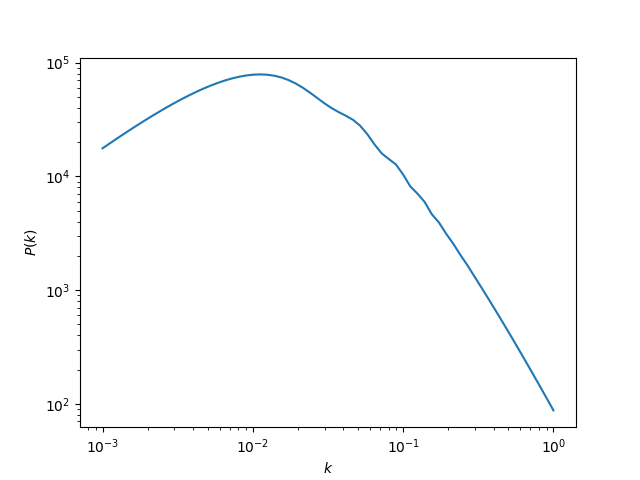

In [27]:
fig, ax = plt.subplots()

ax.plot(kmodes, Pkm, label='delta_m')
ax.loglog()
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

In [48]:
def power_Kaiser( *, y : jax.Array, kmodes : jax.Array, b : float, aexp : float, sigma_z0 : float, nmu : int, param ) -> tuple[jax.Array]:
    """ compute the anisotropic power spectrum using the Kaiser formula
    
    Args:
        y (array_like)       : input solution from the EB solver
        kmodes (array_like)  : the list of wave numbers
        b (float)            : linear tracer bias
        aexp (float)         : scale factor
        sigma_z0 (float)     : redshift error sigma_z = sigma_z0 * (1+z)
        nmu (int)            : number of mu bins
        param (dict)         : dictionary of all data

    Returns:
        P(k,mu) (array_like) : anisotropic spectrum
        mu (array_like)      : mu bins
        theta (array_like)   : theta bins, mu = cos(theta)
    """
    alpha = jnp.linspace(-jnp.pi,jnp.pi,nmu,endpoint=False)
    mu = jnp.cos( alpha )

    rhonu = jnp.exp(param['logrhonu_of_loga_spline'].evaluate(jnp.log(aexp)))
    rho_Q = aexp**(-3*(1+param['w_DE_0']+param['w_DE_a'])) * jnp.exp(3*(aexp-1)*param['w_DE_a'])
    
    # ... background energy density
    grho = (
        param['grhom'] * param['Omegam'] / aexp
        + (param['grhog'] + param['grhor'] * (param['Neff'] + param['Nmnu'] * rhonu)) / aexp**2
        + param['grhom'] * param['OmegaDE'] * rho_Q * aexp**2
        + param['grhom'] * param['Omegak']
    )
    
    aprimeoa = jnp.sqrt(grho / 3.0)

    fac = 2 * jnp.pi**2 * param['A_s']
    deltam = jnp.sqrt(fac *(kmodes/param['k_p'])**(param['n_s'] - 1) * kmodes**(-3)) * y[:,4]
    thetam = jnp.sqrt(fac *(kmodes/param['k_p'])**(param['n_s'] - 1) * kmodes**(-3)) * y[:,5]

    # photo-z error
    h = param['H0'] / 100.
    sigma_z = sigma_z0 / aexp
    Fkmu = jnp.exp( -(kmodes[:,None] / aprimeoa)**2 * mu[None,:]**2 * sigma_z**2 )

    # thetam already contains 1/ mathcal{H} factor   -f delta = theta
    Pkmu =  (b*deltam[:,None] - mu[None,:]**2 * thetam[:,None])**2 * Fkmu
    # 
    # f = 0.5223719
    # Pkmu =  (b*deltam[:,None] + f * mu[None,:]**2 * deltam[:,None])**2 * Fkmu
    
    return Pkmu, mu, alpha

In [49]:
p1, mu1, a1 = power_Kaiser(y=y[:,-1,:], kmodes=kmodes, b=0.2, aexp=1.0, sigma_z=0.01, nmu = 32, param=param)

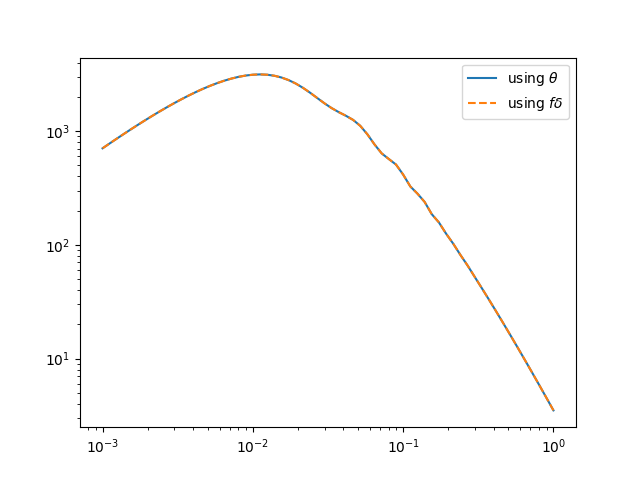

In [52]:
fig, ax = plt.subplots()
f = 0.5223719
# ax.plot( kmodes, f * y[:,-1,4],'x-', label='$f \\delta$')
# ax.plot( kmodes, -y[:,-1,5] , '--', label='$\\theta$')
ax.plot( kmodes, p1[...,8],label='using $\\theta$')
ax.plot( kmodes, p2[...,8],'--',label='using $f \\delta$')

ax.loglog()
ax.legend()

In [37]:
p.shape

(64, 32)